In [57]:
import pandas as pd
import numpy as np

def get_df():
    """Imports and cleans music data in dataframe"""
    df = pd.read_csv('My_Music.csv')
    df.columns = df.columns.str.lower()
    
    #dtypes
    df['date added'] = pd.to_datetime(df['date added'])
    df['last played'] = pd.to_datetime(df['last played'])
    
    #Loved
    df.drop(df[df['loved'] == '5/31/2016 7:03 PM'].index, inplace=True)
    df.drop(df[df['loved'].isnull() == True].index, inplace=True)
    df.loc[:,'loved'] = df['loved'].astype(int) > 0
    
    #rating to stars
    df.loc[:,'rating'].fillna(0, inplace=True)
    df.loc[:,'rating'] = df['rating']/20
    df.loc[:,'rating'] = df['rating'].astype(float)
    df.rename(columns={'rating':'stars', 'name':'song'}, inplace=True)
    df.loc[(df[(df['stars'] > 2) & (df['loved'] == False)].index), 'stars'] = 0
    
    return df

get_df().sort_values('date added', ascending=False).head()

,album artist,song,time,artist,album,genre,loved,plays,date added,stars,year,last played
3178,NaN,Caledonia Soul Music,17:15,Van Morrison,NaN,Jam Session,True,4.0,2020-09-11 13:03:00,0.0,NaN,2020-09-12 11:11:00
3179,Jim Croce,Operator (That's Not the Way It Feels),3:50,Jim Croce,You Don't Mess Around With Jim,Rock,False,2.0,2020-09-10 23:26:00,0.0,1972.0,2020-09-12 11:15:00
3180,Jim Croce,"Bad, Bad Leroy Brown",3:02,Jim Croce,Life & Times,Rock,True,3.0,2020-09-10 23:18:00,0.0,1973.0,2020-09-12 11:23:00
3181,Bon Iver,U (Man Like),2:26,Bon Iver,"i,i",Alternative,False,2.0,2020-09-10 22:04:00,0.0,2019.0,2020-09-12 11:25:00
3182,Bon Iver,Jelmore,2:30,Bon Iver,"i,i",Alternative,False,2.0,2020-09-10 22:04:00,0.0,2019.0,2020-09-12 11:27:00


In [111]:
def get_artist_stats(listened_since = '1990', added_since = '1990', sort = 'adj. rating', added_before = '2040'):
    """
    Returns a sorted pivot table containing information on artists whose songs have been 
    played since a given datetime. Aggregates total number of stars, total number of plays 
    of the songs, and number of songs.
    """
    
    df = get_df()
    df = df[df['last played'] > listened_since]
    df = df[df['date added'] < added_before]    
    df = df[df['date added'] > added_since]
    
    df.loc[(df[(df['stars'] == 0) & (df['loved'] == True)].index), 'stars'] = 2.5
    df.loc[(df[(df['stars'] == 2)].index), 'stars'] = 0

    
    df['adj. rating'] = df['stars']**2 / 2.5
    df['comp. score'] = df['stars']**2 / 2.5 + np.sqrt(df['plays'])

    df = df[['artist', 'song', 'stars', 'plays', 'loved', 'adj. rating', 'comp. score', 'year']].groupby('artist').agg({'song':'count', 
                                                                                  'stars':sum, 'loved':sum, 'plays':sum, 
                                                                                  'adj. rating':sum, 'comp. score':sum, 
                                                                                  'year':'mean' }).round(0).fillna(0).astype(int)
    df.rename(columns = {'song': 'songs', 'year':'avg. year'}, inplace=True)
    
    #Feature Engineering
    df['(songs / loved)'] = (df['songs'] / df['loved']).round(2)
    df['(songs / loved)'].replace(np.inf, 0, inplace=True)    
    
    df['(stars / songs)'] = (df['stars'] / df ['songs']).round(1)

    df['(comp.**2 / loved)'] = (df['comp. score']**2 / df['loved']).round(1)
    df['(comp.**2 / loved)'].replace(np.inf, 0, inplace=True)
    
    df['(adj. rating * (songs/loved))'] = (df['adj. rating'] * (df['songs']/df['loved'])).round(1)
    
    df['Stat Composite'] = ((df['songs']/np.max(df['songs']) + df['loved']/np.max(df['loved']) + df['stars']/np.max(df['stars']) + df['plays']/np.max(df['plays']) + df['adj. rating']/np.max(df['adj. rating']))*(100/5)).round(2)
    df['Feature Composite'] = ((df['(comp.**2 / loved)']/np.max(df['(comp.**2 / loved)']) + df['(adj. rating * (songs/loved))']/np.max(df['(adj. rating * (songs/loved))']))*(100/2)).round(2)

    
    return df.sort_values(sort, ascending=False)

get_artist_stats(listened_since = '2017', sort='Feature Composite').head(25)

,songs,stars,loved,plays,adj. rating,comp. score,avg. year,(songs / loved),(stars / songs),(comp.**2 / loved),(adj. rating * (songs/loved)),Stat Composite,Feature Composite
artist,,,,,,,,,,,,,
John Mayer,126,212,61,3423,323,924,2008,2.07,1.7,13996.3,667.2,100.00,100.00
Jack Johnson,120,144,45,2055,200,641,2008,2.67,1.2,9130.7,533.3,71.78,72.58
Ben Howard,46,78,18,713,139,304,2014,2.56,1.7,5134.2,355.2,33.33,44.96
Trevor Hall,63,66,20,780,94,296,2012,3.15,1.0,4380.8,296.1,33.16,37.84
Jason Mraz,52,105,29,1091,158,360,2010,1.79,2.0,4469.0,283.3,43.83,37.20
ODESZA,42,30,8,668,49,199,2015,5.25,0.7,4950.1,257.2,19.06,36.96
Zac Brown Band,49,90,26,1218,132,335,2015,1.88,1.8,4316.3,248.8,40.08,34.06
Ed Sheeran,56,76,23,855,108,299,2015,2.43,1.4,3887.0,263.0,35.28,33.60
Lord Huron,40,80,22,1021,125,317,2015,1.82,2.0,4567.7,227.3,34.81,33.35


In [95]:
def get_genre_stats(listened_since = '1990', added_since = '1990', sort = 'stars'):
    """
    Returns a sorted pivot table containing information on artists whose songs have been 
    played since a given datetime. Aggregates total number of stars, total number of plays 
    of the songs, and number of songs.
    """
    
    
    df = get_df()
    df = df[df['last played'] > listened_since]
    df = df[df['date added'] > added_since]
    df = df[['genre', 'song', 'stars', 'plays', 'loved']].groupby('genre').agg({'song':'count', 
                                                                                  'stars':sum, 
                                                                                  'loved':sum,
                                                                                  'plays':sum, }).astype(int)
    df.rename(columns = {'song': 'songs'}, inplace=True)
    
    return df.sort_values(sort, ascending=False)

get_genre_stats().head(15)

,songs,stars,loved,plays
genre,,,,
Pop,1339,1241,470,14544
Dance,636,735,222,7389
Alternative,780,650,210,7947
Rock,545,483,186,7832
Country,314,285,114,5340
Hip-Hop/Rap,280,269,106,1387
R&B/Soul,261,244,102,2378
Singer/Songwriter,304,208,73,2795
Rap & Hip-Hop,444,187,87,3249


In [138]:
def top_artists(songtolovedfactor = 1.5, listened_since = '2019', added_before = '2040', added_since = '2016'):
    """
    Returns a list of top artists by excluding artists that fall beneath thresholds of songs, 
    loved songs, and songs per loved song (to exclude artists making the list whose previously 
    loved hits were the only ones listened to)
    """
    df = get_artist_stats(listened_since = listened_since, added_before=added_before, added_since=added_since, sort='Stat Composite')
    df = df[(df['loved'] > 4) & (df['(songs / loved)'] > songtolovedfactor)]
    return df

top_artists(added_since='2016')

,songs,stars,loved,plays,adj. rating,comp. score,avg. year,(songs / loved),(stars / songs),(comp.**2 / loved),(adj. rating * (songs/loved)),Stat Composite,Feature Composite
artist,,,,,,,,,,,,,
John Mayer,87,154,46,2507,226,663,2009,1.89,1.8,9555.8,427.4,97.94,100.00
Jack Johnson,97,128,41,1760,175,551,2007,2.37,1.3,7404.9,414.0,83.98,87.18
Lord Huron,39,80,22,1014,125,315,2015,1.77,2.1,4510.2,221.6,47.15,49.52
Ben Howard,44,78,18,701,139,300,2013,2.44,1.8,5000.0,339.8,44.92,65.91
The California Honeydrops,44,60,17,664,90,247,2017,2.59,1.4,3588.8,232.9,37.52,46.02
The Tallest Man On Earth,32,66,19,567,100,222,2014,1.68,2.1,2593.9,168.4,36.80,33.27
Hozier,34,41,11,327,64,155,2017,3.09,1.2,2184.1,197.8,25.39,34.57
Trevor Hall,22,40,11,442,64,159,2014,2.00,1.8,2298.3,128.0,23.70,27.00
ODESZA,33,30,8,608,49,178,2015,4.12,0.9,3960.5,202.1,23.37,44.37


<IPython.core.display.Javascript object>


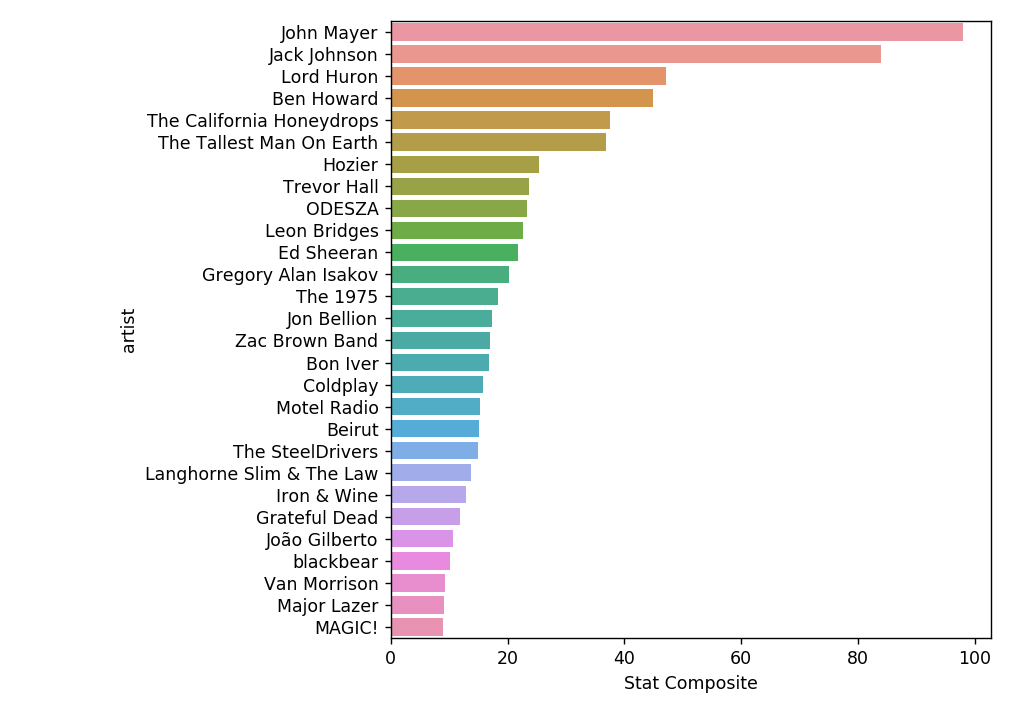

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

top = top_artists()

fig = plt.figure(figsize=(6,5))
sns.barplot(top['Stat Composite'], top.index)
fig.tight_layout()

<IPython.core.display.Javascript object>


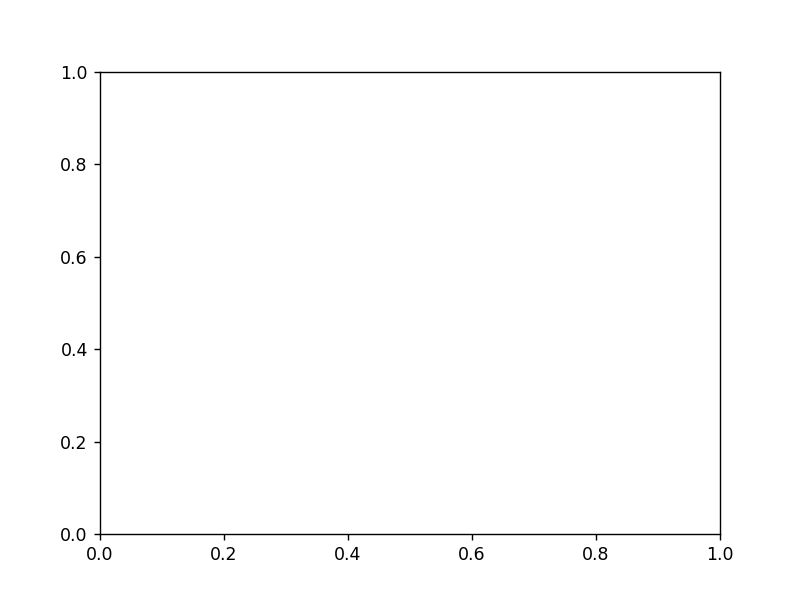

In [135]:
n=88
def update(curr):
    print('running...')
    if curr == n:
        a.event_source.stop()
    plt.cla()
    x = datetime.datetime(2013,8,1) + curr * timedelta(days=365/12)
    top = top_artists(added_before = x, listened_since = '2016').head(15)
    sns.barplot(top['comp. score'], top.index)
    fig.tight_layout()
    plt.annotate('Added before {}'.format(x.date()), (310,47), xycoords='figure points')

%matplotlib notebook
fig = plt.figure()
a = animation.FuncAnimation(fig, update, interval=500)


#a.save('compbydateadded.mp4')